In [1]:
import scipy.io as scipy
import os
import os.path as osp
import pandas as pd
import numpy as np
import pickle
import networkx as nx
from tqdm import tqdm

In [2]:
BASEDIR = os.getcwd()
MAP_NAME = 'NYC_Manhattan_Map.mat'
REQ_NAME = 'Requests.mat'
OUTPUT_NAME = 'Manhattan_Map' 

In [3]:
map = scipy.loadmat(osp.join(BASEDIR,MAP_NAME))

In [4]:
map_Arcs = pd.DataFrame(map['Arcs']) #ArcsID, Node_Origin, Node_destination, starts from 1 
map_CityArcs = pd.DataFrame(map['CityArcs']) #NodeID, NodeID, starting from 1, 1 means connected.
map_EdgeTimes = pd.DataFrame(map['EdgeTimes']) #ArcTime in seconds, position is ArcID
map_Nodes = pd.DataFrame(map['Nodes']) # Node ID, latitude, longtitude
map_dijkstra_A = pd.DataFrame(map['dijkstra_A']) #Unclear
map_dijkstra_V = pd.DataFrame(map['dijkstra_V']).T #shortest time matrix, transpose it to align with others (Oid, Did)

In [49]:
# map_Nodes[map_Nodes['NodeID'] == 3019]['Longitude'] = 73.950005
map_Nodes.loc[map_Nodes['NodeID'] == 3019, 'Longitude'] = -73.950005

In [7]:
# Make the index start from 1
map_CityArcs.index = map_CityArcs.index + 1
map_CityArcs.columns = map_CityArcs.columns + 1
map_dijkstra_V.index = map_dijkstra_V.index + 1
map_dijkstra_V.columns = map_dijkstra_V.columns + 1

In [6]:
map_Arcs.rename(columns={0:'ArcID',1:'Oid',2:'Did'},inplace=True)
map_EdgeTimes.rename(columns={0:'ArcTime'},inplace=True)
map_Nodes.rename(columns={0:'NodeID',1:'Latitude',2:'Longitude'},inplace=True)

In [8]:
map_Nodes['NodeID'] = map_Nodes['NodeID'].astype(int)

In [10]:
map_Nodes[map_Nodes['NodeID'] == 3000]

,NodeID,Latitude,Longitude
2999,3000,40.823119,-73.950496


In [8]:
map_CityArcs

,1,2,3,4,5,6,7,8,9,10,...,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4089,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4090,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
# Add self-Connection to map_CityArcs
for i in range(1, map_Nodes.shape[0]+1):
    map_CityArcs.loc[i,i] = 1

map_CityArcs.sum().sum()- 4091
with open(osp.join(BASEDIR,'NYC_Manhattan_CityArc.pickle'), 'wb') as f:
    pickle.dump(map_CityArcs, f)

In [10]:
map_EdgeTimes.insert(0, "ArcID", range(1, len(map_EdgeTimes) + 1))
map_EdgeTimes

,ArcID,ArcTime
0,1,16
1,2,30
2,3,38
3,4,11
4,5,23
...,...,...
9447,9448,37
9448,9449,93
9449,9450,45
9450,9451,22


In [41]:
# Generate Graph
G = nx.DiGraph()
num_edges = len(map_Arcs) #num of edges in the map
arcs = tqdm(map_Arcs.iterrows(), total=num_edges, ncols=100, desc='Building network...') #ncols is the width of the progress bar

for idx, arcs in arcs:
    Oid = arcs['Oid']
    Did = arcs['Did']
    ArcID = arcs['ArcID']-1 #EdgeTime is indexed from 0
    G.add_node(Oid) #add current node to the graph
    G.add_node(Did) #add destination node to the graph
    G.add_edge(Oid, Did, TimeCost=map_EdgeTimes.iloc[ArcID]['ArcTime']) #add the arc to the graph

print('Network data loaded.')
print(f'Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')

Building network...: 100%|███████████████████████████████████| 9452/9452 [00:00<00:00, 31934.39it/s]

Network data loaded.
Network has 4091 nodes and 9452 edges.


In [42]:
# aggregate nodes to k-areas
from sklearn.cluster import KMeans
from scipy.linalg import eigh

# Convert to undirected graph for aggregation
G_undirected = G.to_undirected()

# 计算标准化拉普拉斯矩阵
L = nx.normalized_laplacian_matrix(G_undirected).astype(float)

# 计算特征值和特征向量
eigenvalues, eigenvectors = eigh(L.toarray())

# 选择前k个特征向量（假设k=100）
k = 100
v = eigenvectors[:, :k]

# 应用k-means聚类
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(v)

# 将聚类结果赋值给每个节点
for i, node in enumerate(G_undirected.nodes()):
    G_undirected.nodes[node]['area'] = clusters[i]
    G_undirected.nodes[node]['longitude'] = map_Nodes.loc[map_Nodes['NodeID'] == node]['Longitude'].values[0]
    G_undirected.nodes[node]['latitude'] = map_Nodes.loc[map_Nodes['NodeID'] == node]['Latitude'].values[0]



In [ ]:
# 输出某个节点的区域信息
print(G_undirected.nodes[1]['area'])
print(G_undirected.nodes[1]['longitude'])
print(G_undirected.nodes[1]['latitude'])

In [43]:
# 检查所有节点是否有有效的经纬度
invalid_nodes = []
for node in G_undirected.nodes:
    lat = G_undirected.nodes[node].get('latitude')
    lon = G_undirected.nodes[node].get('longitude')
    if lat is None or lon is None or np.isnan(lat) or np.isnan(lon):
        invalid_nodes.append(node)

print("Invalid nodes:", invalid_nodes)

Invalid nodes: []


In [44]:
from collections import defaultdict

# 创建一个字典来收集每个区域的节点
areas = defaultdict(list)

# 遍历所有节点，根据它们的'area'属性分类
for node in G_undirected.nodes:
    area = G_undirected.nodes[node]['area']
    areas[area].append(node)

# 打印每个区域及其包含的节点
for area, nodes in areas.items():
    print(f"Area {area}: {len(nodes)} nodes")
    print(f"Nodes in Area {area}: {nodes}\n")

Area 76: 16 nodes
Nodes in Area 76: [1, 4, 2, 7, 3, 6, 8, 5, 10, 14, 9, 11, 13, 12, 21, 18]

Area 17: 34 nodes
Nodes in Area 17: [15, 17, 20, 23, 29, 33, 25, 30, 28, 31, 38, 32, 39, 35, 48, 45, 53, 55, 44, 46, 64, 68, 58, 59, 67, 80, 85, 71, 74, 81, 86, 114, 107, 118]

Area 67: 20 nodes
Nodes in Area 67: [16, 19, 22, 26, 24, 47, 34, 43, 40, 27, 41, 54, 49, 61, 52, 65, 56, 60, 69, 73]

Area 58: 30 nodes
Nodes in Area 58: [159, 42, 36, 37, 51, 63, 50, 72, 57, 62, 96, 66, 95, 70, 76, 75, 101, 79, 97, 98, 158, 110, 144, 126, 207, 192, 173, 186, 284, 274]

Area 87: 39 nodes
Nodes in Area 87: [104, 112, 77, 84, 87, 91, 99, 127, 176, 115, 193, 147, 177, 227, 148, 243, 216, 291, 278, 309, 320, 343, 262, 370, 357, 316, 328, 380, 396, 451, 406, 450, 476, 470, 482, 497, 507, 506, 518]

Area 32: 46 nodes
Nodes in Area 32: [82, 78, 89, 88, 93, 124, 90, 100, 102, 134, 106, 113, 142, 108, 111, 117, 151, 120, 130, 164, 122, 128, 162, 125, 132, 137, 178, 187, 145, 174, 152, 154, 248, 199, 172, 191, 265

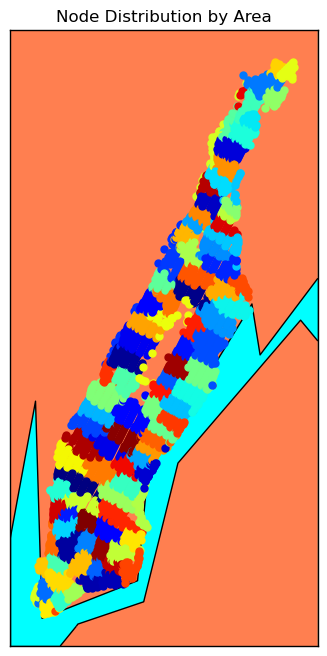

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# 创建新的图形
plt.figure(figsize=(10, 8))

# 设置Basemap，指定我们想要的地图和区域
m = Basemap(projection='merc', llcrnrlat=map_Nodes['Latitude'].min() - 0.01, 
            urcrnrlat=map_Nodes['Latitude'].max() + 0.01,
            llcrnrlon=map_Nodes['Longitude'].min() - 0.01, 
            urcrnrlon=map_Nodes['Longitude'].max() + 0.01, 
            lat_ts=20, resolution='i')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='coral', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

# 转换坐标系统
x, y = m(G_undirected.nodes[node]['longitude'], G_undirected.nodes[node]['latitude'])

# 为每个区域生成一个随机颜色
colors = plt.cm.jet(np.linspace(0, 1, k))
# 为每个节点计算地图上的坐标
coordinates = {node: m(G_undirected.nodes[node]['longitude'], G_undirected.nodes[node]['latitude']) for node in G_undirected.nodes}

# 绘制每个节点
for node in G_undirected.nodes:
    area = G_undirected.nodes[node]['area']
    x, y = coordinates[node]  # 获取坐标
    m.plot(x, y, marker='o', color=colors[area], markersize=5)

plt.title('Node Distribution by Area')
plt.show()

In [46]:
import matplotlib.colors as mcolors
import folium

# 为每个区域生成一个随机颜色
colors = plt.cm.jet(np.linspace(0, 1, k))

# 创建Folium地图对象
center_latitude = np.nanmean([G_undirected.nodes[node]['latitude'] for node in G_undirected.nodes])
center_longitude = np.nanmean([G_undirected.nodes[node]['longitude'] for node in G_undirected.nodes])
m = folium.Map(location=[center_latitude, center_longitude], zoom_start=12, tiles='OpenStreetMap')

# 绘制每个节点
for node in G_undirected.nodes:
    area = G_undirected.nodes[node]['area']
    color = mcolors.rgb2hex(colors[area])
    folium.CircleMarker(
        location=[G_undirected.nodes[node]['latitude'], G_undirected.nodes[node]['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# 保存或显示地图
m.save('map.html')  # 将地图保存为 HTML 文件

In [12]:
all_path_matrix = np.zeros((G.number_of_nodes()+1, G.number_of_nodes()+1))
num_of_nodes = G.number_of_nodes()

In [12]:
# Compute all path matrix (Efficient!)
nodes = tqdm(range(1, num_of_nodes+1), ncols=100, desc='Computing all_path_matrix')
for current_node in nodes:
    path = dict(nx.single_source_dijkstra_path(G, current_node, cutoff=None, weight='TimeCost'))
    # timeCost = dict(nx.single_source_dijkstra_path_length(G, current_node, cutoff=None, weight='TimeCost'))
    for target_node_ID in range(1, num_of_nodes+1):
        current_path = path[target_node_ID]
        for node_idx in range(len(current_path)):
            if node_idx == len(current_path)-1: #last node, also handle self-connection route
                all_path_matrix[current_path[node_idx]][target_node_ID] = int(target_node_ID)
                continue
            all_path_matrix[current_path[node_idx]][target_node_ID] = int(current_path[node_idx+1])
            

with open(BASEDIR + '/NYC_Manhattan_AllPathMatrix.pickle', 'wb') as f:
    pickle.dump(all_path_matrix, f)

Computing all_path_matrix: 100%|████████████████████████████████| 4091/4091 [04:58<00:00, 13.72it/s]


In [13]:
# Save all path time matrix (Efficient!)
with open(BASEDIR + '/NYC_Manhattan_AllPathTimeMatrix.pickle', 'wb') as f:
     pickle.dump(map_dijkstra_V, f)

In [ ]:
# # Compute all path time matrix (Efficient!)
# map_Arcs_with_Time = map_Arcs.merge(map_EdgeTimes, on='ArcID')
# all_path_time_matrix = np.zeros((G.number_of_nodes()+1, G.number_of_nodes()+1))

# ArcIDs = tqdm(range(1, len(map_Arcs_with_Time)+1), ncols=100, desc='Computing all_path_time_matrix')
# for current_Arc_ID in ArcIDs:
#     Oid = map_Arcs_with_Time.loc[map_Arcs_with_Time['ArcID'] == current_Arc_ID, 'Oid']
#     Oid = Oid.values[0]
#     Did = map_Arcs_with_Time.loc[map_Arcs_with_Time['ArcID'] == current_Arc_ID, 'Did']
#     Did = Did.values[0]
#     ArcTime = map_Arcs_with_Time.loc[map_Arcs_with_Time['ArcID'] == current_Arc_ID, 'ArcTime']
#     ArcTime = ArcTime.values[0]
#     all_path_time_matrix[Oid][Did] = ArcTime
# all_path_time_matrix
# with open(BASEDIR + '/NYC_Manhattan_AllPathTimeMatrix.pickle', 'wb') as f:
#     pickle.dump(all_path_time_matrix, f)

In [ ]:
# Compute All Path Table (Inefficient!)

print('Computing the shortest path for every node pair')
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

all_path_table = {} 

rng = tqdm(range(1, num_nodes+1), ncols=100, desc='Computing all_path_table')
for node in rng:
    all_path_table[node] = dict(nx.single_source_dijkstra_path(G, node, cutoff=None, weight='TimeCost'))
    path = dict(nx.single_source_dijkstra_path(G, node, cutoff=None, weight='TimeCost'))
    timeCost = dict(nx.single_source_dijkstra_path_length(G, node, cutoff=None, weight='TimeCost'))
    path_timeCost_dict = {k: (path[k], timeCost[k]) for k in path.keys()}
    all_path_table[node] = path_timeCost_dict #store the path and time cost for each node

with open(BASEDIR + '/NYC_Manhattan_AllPathTable.pickle', 'wb') as f:
    pickle.dump(all_path_table, f)

In [17]:
# Load Requests File
BASEDIR = os.getcwd()
REQ_NAME = 'NYC_Andres_data/Requests10DaysReduced.mat'
req = scipy.loadmat(osp.join(BASEDIR,REQ_NAME))
req_matrix = pd.DataFrame(req['Requests10DaysReduced']) #Orid, Did, ReqTime(mins, need to add random secs for this), size of req
req_matrix.columns = [f'day{i+1}'for i in range(10)]
req_matrix

,day1,day2,day3,day4,day5,day6,day7,day8,day9,day10
0,"[[423, 409, 0, 5], [1692, 1447, 0, 1], [2363, ...","[[7, 1681, 0, 1], [2816, 1315, 0, 5], [1627, 3...","[[884, 726, 0, 2], [1634, 1544, 0, 1], [1288, ...","[[408, 617, 0, 1], [2192, 2758, 0, 1], [2311, ...","[[2831, 2499, 0, 1], [1262, 1465, 0, 3], [367,...","[[1593, 1966, 0, 1], [2040, 2886, 0, 1], [1082...","[[1565, 471, 0, 1], [2497, 2628, 0, 1], [41, 1...","[[1829, 2077, 0, 1], [973, 1811, 0, 1], [1759,...","[[1621, 2025, 0, 2], [1296, 2822, 0, 1], [1904...","[[3295, 856, 0, 1], [1055, 1185, 0, 5], [650, ..."


In [18]:
df_days = []
for i in range(1,11):
    req_day = req_matrix[f'day{i}']
    # 使用 explode 将列表展开成行
    df_exploded = req_day.explode(f'day{i}').reset_index(drop=True)
    # 将每个列表转换成多个列
    df_final = pd.DataFrame(df_exploded.tolist(), columns=['Oid', 'Did', 'ReqTime', 'Size'])
    df_days.append(df_final)
df_days

[        Oid   Did  ReqTime  Size
 0       423   409        0     5
 1      1692  1447        0     1
 2      2363  2173        0     1
 3      2684  2561        0     1
 4        16    16        0     1
 ...     ...   ...      ...   ...
 19965   354   351      119     2
 19966  1136  1501      119     1
 19967  1366  1081      119     1
 19968  1908  1166      119     1
 19969  1745  3942      119     1
 
 [19970 rows x 4 columns],
         Oid   Did  ReqTime  Size
 0         7  1681        0     1
 1      2816  1315        0     5
 2      1627  3942        0     5
 3      2104  2451        0     1
 4       216  2137        0     3
 ...     ...   ...      ...   ...
 23140   862  1333      119     1
 23141  1324  3912      119     1
 23142  1398  1769      119     1
 23143  2119  1597      119     1
 23144   950  1292      119     1
 
 [23145 rows x 4 columns],
         Oid   Did  ReqTime  Size
 0       884   726        0     2
 1      1634  1544        0     1
 2      1288  1701      

In [19]:
for day in range(1,11):
    req_matrix = df_days[day-1]
    # Convert ReqTime to seconds
    req_matrix['ReqTime'] = req_matrix['ReqTime'] * 60

    # Generate random numbers between 0 and 59
    random_seconds = np.random.randint(0, 60, size=len(req_matrix))

    # Add random seconds to ReqTime column
    req_matrix['ReqTime'] += random_seconds
    req_matrix.sort_values(by='ReqTime', inplace=True)

    # Add reqID 
    req_matrix.insert(0, "ReqID", range(1, len(req_matrix) + 1))

    # save as csv
    req_matrix.to_csv(BASEDIR + '/' + f'NYC_Manhattan_Requests_day{day}.csv', index=False)
    # print(req_matrix)

In [6]:
req_matrix.rename(columns={0:'Oid',1:'Did',2:'ReqTime',3:'Size'},inplace=True)
req_matrix

,Oid,Did,ReqTime,Size,4,5,6,7,8,9
0,"[[423, 409, 0, 5], [1692, 1447, 0, 1], [2363, ...","[[7, 1681, 0, 1], [2816, 1315, 0, 5], [1627, 3...","[[884, 726, 0, 2], [1634, 1544, 0, 1], [1288, ...","[[408, 617, 0, 1], [2192, 2758, 0, 1], [2311, ...","[[2831, 2499, 0, 1], [1262, 1465, 0, 3], [367,...","[[1593, 1966, 0, 1], [2040, 2886, 0, 1], [1082...","[[1565, 471, 0, 1], [2497, 2628, 0, 1], [41, 1...","[[1829, 2077, 0, 1], [973, 1811, 0, 1], [1759,...","[[1621, 2025, 0, 2], [1296, 2822, 0, 1], [1904...","[[3295, 856, 0, 1], [1055, 1185, 0, 5], [650, ..."


In [23]:
# Convert ReqTime to seconds
req_matrix['ReqTime'] = req_matrix['ReqTime'] * 60

# Generate random numbers between 0 and 59
random_seconds = np.random.randint(0, 60, size=len(req_matrix))

# Add random seconds to ReqTime column
req_matrix['ReqTime'] += random_seconds
req_matrix.sort_values(by='ReqTime', inplace=True)

# Add reqID 
req_matrix.insert(0, "ReqID", range(1, len(req_matrix) + 1))

# save as csv
# req_matrix.to_csv(BASEDIR + '/' + 'NYC_Manhattan_Requests.csv', index=False)
req_matrix

,ReqID,Oid,Did,ReqTime,Size
0,1,1023,1569,0,6
131,2,2403,1539,0,1
40,3,1194,663,0,1
61,4,220,1272,0,1
67,5,2139,2124,1,5
...,...,...,...,...,...
10594,10770,3942,1811,3598,2
10726,10771,2060,994,3598,2
10761,10772,1004,2026,3599,1
10603,10773,1468,36,3599,1


In [24]:
PATH_MANHATTAN_ALL_PATH_TIME_MATRIX = f"./NYC_Manhattan_AllPathTimeMatrix.pickle"
with open(PATH_MANHATTAN_ALL_PATH_TIME_MATRIX, 'rb') as t:
    ALL_PATH_TIME_MATRIX = pickle.load(t)

In [25]:
# Delete requests that can be completed within 3 minutes(too short)
for index, row in req_matrix.iterrows():
    reqID = row['ReqID']
    Oid = row['Oid']
    Did = row['Did']
    timeCost = ALL_PATH_TIME_MATRIX[Oid][Did]
    if timeCost <= 180:
        req_matrix.drop(index, inplace=True)


In [26]:
# Refresh ReqID
req_matrix.drop(columns=['ReqID'], inplace=True)
req_matrix.insert(0, "ReqID", range(1, len(req_matrix) + 1))

In [27]:
req_matrix

,ReqID,Oid,Did,ReqTime,Size
0,1,1023,1569,0,6
131,2,2403,1539,0,1
40,3,1194,663,0,1
61,4,220,1272,0,1
67,5,2139,2124,1,5
...,...,...,...,...,...
10594,9957,3942,1811,3598,2
10726,9958,2060,994,3598,2
10761,9959,1004,2026,3599,1
10603,9960,1468,36,3599,1


In [28]:
# save as csv
req_matrix.to_csv(BASEDIR + '/' + 'NYC_Manhattan_Requests.csv', index=False)